In [1]:

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy


class LinearRegression2GPU():
    
    def __init__(self,squaredError=True):
        mod = SourceModule("""
  
  
  __global__ void linearRegression(float *ssxy, float* ssxx,float *x, float *y,float xMean1,float yMean1,float xMean2,float yMean2, unsigned int limit,unsigned int midway)
  {
    unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx<limit) {
        if (idx<midway) {
            float xx=x[idx]-xMean1;
            float yy=y[idx]-yMean1;
            ssxx[idx]=xx*xx;
            ssxy[idx]=xx*yy;    
        }
        else {
            float xx=x[idx]-xMean2;
            float yy=y[idx]-yMean2;
            ssxx[idx]=xx*xx;
            ssxy[idx]=xx*yy;    
        }

    }
  }

  
  __global__ void distanceToFit(float *distances,unsigned int *x, float* y,float a1, float b1,float a2,float b2,unsigned int limit,unsigned int midway)
  {
    unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx<limit) {
        if (idx<midway) distances[idx]=fabsf((x[idx]*b1+a1)-y[idx]);
        else distances[idx]=fabsf((x[idx]*b2+a2)-y[idx]);
    }
  }

  __global__ void squaredError(float *distances,unsigned int *x, float* y,float a1, float b1,float a2,float b2,unsigned int limit,unsigned int midway)
  {
    unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx<limit) {
        if (idx<midway){
        float dist=(x[idx]*b1+a1)-y[idx];
         distances[idx]=dist*dist;
        }
        else {
        float dist=(x[idx]*b2+a2)-y[idx];
        distances[idx]=dist*dist;
        }
    }
  }

  
  """)
        self.distanceToPlot=None
        self.linearRegressionGPU=mod.get_function("linearRegression")
        if (squaredError):
            self.error=mod.get_function("squaredError")
        else:
            self.error=mod.get_function("distanceToFit")
        self.lowestDistance=None
        self.bestCutoff=None
        self.fits=None
        
        
        
    def fit(self, x, y):    
        elements=len(x)

        x = numpy.ascontiguousarray(x.astype(numpy.float32))
        y = numpy.ascontiguousarray(y.astype(numpy.float32))

        x_gpu = cuda.mem_alloc(x.nbytes)
        y_gpu = cuda.mem_alloc(y.nbytes)

        cuda.memcpy_htod(x_gpu, x)
        cuda.memcpy_htod(y_gpu, y)

        ssxy = numpy.empty_like(x)
        ssxx = numpy.empty_like(x)

        ssxy_gpu = cuda.mem_alloc(ssxy.nbytes)
        ssxx_gpu = cuda.mem_alloc(ssxx.nbytes)

        distances_gpu = cuda.mem_alloc(x.nbytes)
        distances=numpy.empty_like(x)

        grid = ((elements//512)+1, 1)
        block = (512, 1, 1)
        self.linearRegressionGPU.prepare(("P","P","P","P","f","f","f","f","I","I"))
        self.error.prepare(("P","P","P","f","f","f","f","I","I"))


        self.distanceToPlot=[]
        for i in range(2,elements-2):
            midway=i

            xmean1=numpy.float32(numpy.mean(x[0:midway]))
            ymean1=numpy.float32(numpy.mean(y[0:midway]))
            xmean2=numpy.float32(numpy.mean(x[midway:]))
            ymean2=numpy.float32(numpy.mean(y[midway:]))


            self.linearRegressionGPU.prepared_call(grid, block, ssxy_gpu, ssxx_gpu ,x_gpu,y_gpu,xmean1,ymean1,xmean2,ymean2,elements,midway)


            cuda.memcpy_dtoh(ssxy, ssxy_gpu)
            cuda.memcpy_dtoh(ssxx, ssxx_gpu)


            slope1=numpy.sum(ssxy[:midway])/numpy.sum(ssxx[:midway])
            intercept1=ymean1-slope1*xmean1

            slope2=numpy.sum(ssxy[midway:])/numpy.sum(ssxx[midway:])
            intercept2=ymean2-slope2*xmean2


            self.error.prepared_call(grid, block, distances_gpu, x_gpu ,y_gpu,intercept1,slope1,intercept2,slope2,elements,midway)

            cuda.memcpy_dtoh(distances, distances_gpu)

            distance=numpy.sum(distances)
            self.distanceToPlot.append(distance)
            if self.lowestDistance is None:
                self.lowestDistance=distance
                self.fits=((slope1,intercept1),(slope2,intercept2))
                self.bestCutoff=midway
            elif distance<self.lowestDistance:
                self.lowestDistance=distance
                self.fits=((slope1,intercept1),(slope2,intercept2))
                self.bestCutoff=midway


                




Class to obtain the 2 regimes

In [2]:
import collections

with open('Alice.txt', 'r') as file:
    data = file.read().split()

y = data
c = collections.Counter(y)
x=numpy.array(range(1,len(c)+1))
y=[]
for key in c:
    y.append(c[key])
y.sort(reverse=True)
y=numpy.array(y)
xToFit=numpy.log(x)
yToFit=numpy.log(y)


Turn file into zipf distribution

In [3]:

logisticRegressor=LinearRegression2GPU() 

logisticRegressor.fit(xToFit,yToFit) 

print(logisticRegressor.lowestDistance)
print(logisticRegressor.bestCutoff)
print(logisticRegressor.fits)


2.6233997e+21
2269
((-0.9859226, 8.104928), (-0.05733886, 0.48323816))


Fit to distribution and find point where first regime ends and second regime begins

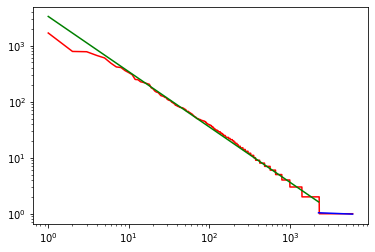

In [4]:
import matplotlib.pyplot as plt

x2 = numpy.linspace(1,logisticRegressor.bestCutoff,logisticRegressor.bestCutoff)
x2=-numpy.sort(-x2)
x2=numpy.log(x2)
y2 = x2*logisticRegressor.fits[0][0]+logisticRegressor.fits[0][1]

x3 = numpy.linspace(logisticRegressor.bestCutoff,len(x)+1,len(x)+1)
x3=-numpy.sort(-x3)
x3=numpy.log(x3)
y3 = x3*logisticRegressor.fits[1][0]+logisticRegressor.fits[1][1]


plt.loglog(x,y, color='r')
plt.loglog(numpy.exp(x2),numpy.exp(y2),color='g')

plt.loglog(numpy.exp(x3),numpy.exp(y3),color='b')

plt.show()

Plot both regimes on top of the zipf distribution

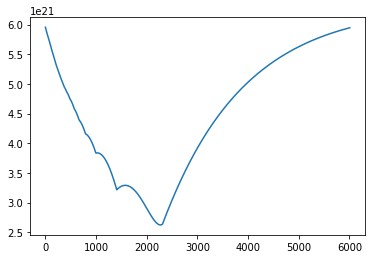

In [5]:
import matplotlib.pyplot as plt

x4 = range(2,len(x)-2)
y4 = logisticRegressor.distanceToPlot

plt.plot(x4, y4)

plt.show()

Plot the distances obtained in each of the points observed as the point of regime change